In [1]:
%matplotlib inline
# change scale of all figures to make them bigger
import matplotlib as mpl
mpl.rcParams['savefig.dpi']=100 

General reminder: Anderson impurity model and CTHYB solver
=========================================

In the Anderson impurity model, we decompose the full lattice problem into an interacting site ('impurity') hybridised to a bath:

<img src="files/dmft_bath_impurity.png">

with the Hamiltonian
   \begin{align*}
     H = & \color{red}{H_{\rm imp}} + \color{darkgreen}{H_{\rm hyb}} + \color{blue}{H_{\rm bath}} \\
     \color{red}{H_{\rm imp}} = & \sum_{\alpha \beta} \epsilon_{\alpha \beta} c^{\dagger}_{\alpha} c_{\beta} 
     + \sum_{\alpha \beta \gamma \delta} U_{\alpha \beta \gamma \delta} c^{\dagger}_{\alpha} c^{\dagger}_{\beta} c_{\delta} c_{\gamma} \\
     \color{darkgreen}{H_{\rm hyb}} = & \sum_{\alpha \nu k} (V_{\alpha \nu k} c^{\dagger}_{\alpha} d_{\nu k} + h.~c.) \\
     \color{blue}{H_{\rm bath}} = & \sum_{\nu k} \epsilon_{\nu k} d^{\dagger}_{\nu k} d_{\nu k}.
   \end{align*}

Without going into the gory details, the basic idea behind CTHYB is to solve the impurity model by diagrammatically expanding the partition function $Z$ and sample the diagrams stochastically using Monte Carlo while measuring quantities of interest, such as the Green's function.

The key point to understand is that a CTHYB solver needs two pieces of information as input from the user:
- the **interacting Hamiltonian**, $H_{\rm int} = \sum_{\alpha \beta \gamma \delta} U_{\alpha \beta \gamma \delta} c^{\dagger}_{\alpha} c^{\dagger}_{\beta} c_{\delta} c_{\gamma}$,
- the **non-interacting Green's function**, $G_0(i\omega_n)$, from which the energy levels $\epsilon$ and hybridization function are deduced.

The TRIQS/CTHYB impurity solver
===============================

In this notebook, we will see how to use the CTHYB impurity solver ([documentation here](https://triqs.github.io/cthyb/)). We will take
the example of a single-orbital Anderson impurity model with a local Coulomb interaction on
the impurity orbital

$$
H_\mathrm{int} = U n_\mathrm{\uparrow} n_\mathrm{\downarrow}
$$

The non-interacting Green's function is

$$
G_0(i\omega_n) = \frac{1}{i\omega_n - \epsilon_d - V^2 \Gamma(i\omega_n)}
$$

and $\Gamma$ is the Green's function of a flat conduction bath.

Setting up the impurity solver
------------------------------

Here is an example showing how to define an impurity solver and run it on a
single-orbital Anderson impurity model. Note that the Monte Carlo will take a bit
of time. Wait until the calculation is over before going on (see the "Kernel busy"
solid circle on the top right).

In [2]:
from triqs.gf import *
from triqs.operators import *
from triqs_cthyb import Solver

# Redirect the output of the C++ solver to the notebook
from triqs.utility.redirect import *
start_redirect()

V = 1.0           # Hybridization strength
U = 4.0           # Local (on-site) Coulomb interaction
epsilon_d = 0.2   # Orbital energy level
beta = 20         # Inverse temperature

# Construct the impurity solver
S = Solver(beta = beta, gf_struct = [('up',[0]), ('down',[0])] )

# Define the non-interacting Green's function
S.G0_iw << inverse(iOmega_n - epsilon_d - V**2 * Flat(1.0))

# Define the interacting Hamiltonian
h_int = U * n('up',0) * n('down',0)

# Solve the impurity problem for a given local Hamiltonian.
S.solve(h_int = h_int, 
        length_cycle = 10,         # Number of steps between each measurement
        n_warmup_cycles = 5000,    # Number of warmup cycles
        n_cycles = 50000           # Number of QMC cycles
       )

Starting run with 1 MPI rank(s) at : 2022-04-25 13:29:21.578588
     .... max_element |g(0) + g(beta) + 1| = 0.0404281
     .... max_element |g(0) + g(beta) + 1| = 0.0582556


Let's try to explain the different lines of the script above. To construct the solver all that is needed is the inverse temperature $\beta$ and a list that describes the block structure of the Green's function. This is the `gf_struct` keyword. In this specific case, there are two (disconnected) blocks `up` and `down` and each containing only one orbital with the index 0. This is what is described by `gf_struct`.

Then, the member `S.G0_iw` of the solver is initialized. This Green's function will be used as the non-interacting Green's function when the solver starts.

The final step is to run the solver with the `solve` method. It has a certain number of parameters:

- `h_int`: This is the interacting Hamiltonian (i.e. the quartic terms in the local Hamiltonian, those with 4 operators) solved for in the Monte Carlo. It is defined using the operators that we have seen in the previous notebook. **Important**: the name of the indices in the operators have to be compatible with the `gf_struct` that was used in the construction of the solver.
- `length_cycle`: This is the number of steps at which measurements, e.g. of `G_tau`, are made to ensure data is decorrelated.
- `n_warmup_cycles`: The number of cycles used to thermalize the system.
- `n_cycles`: This is the number of Monte Carlo cycles, which is also the number of measures of the Green's function.

So a calculation will have a Markov chain of length `length_cycle` * (`n_warmup_cycles` + `n_cycles`).

When the run is over, the outputs of the solver are:

- `S.G_tau`: The Green's function in imaginary time of the system.
- `S.G_iw`: The Green's function in Matsubara frequency of the system.
- `S.Sigma_iw`: The self-energy in Matsubara frequency.

**Tips for advanced use**:
- For some more complex standard Hamiltonians, the library provides functions that can be used to construct `h_int`. See the operators section of the TRIQS documentation.
- It is likely that for more involved calculations, you will have more parameters that you can adjust. See the online CTHYB documentation.
- If you have many more parameters, it can be beneficial to set the parameters in a dictionary at the top of your script and simply pass the dictionary to `solve` using Python keyword arguments:

```
p = {}                        # Initialize an empty Python dictionary
p['length_cycle'] = 10        # Fill the dictionary with parameters
p['n_warmup_cycles'] = 5000
p['n_cycles'] = 50000

S.solve(h_int = h_int, **p)   # The dictionary contents will be unrolled as arguments to the solve function

```

Visualizing the Matsubara-frequency results
-------------------------------------------

We can plot the results and see how our statistics look in terms of the resulting noise.

(0.0, 20.0)

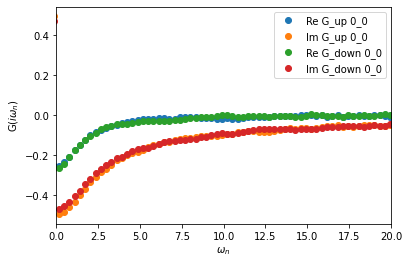

In [3]:
from triqs.plot.mpl_interface import *

oplot(S.G_iw, 'o')
plt.xlim(0,20)

(-1.0, 2.0)

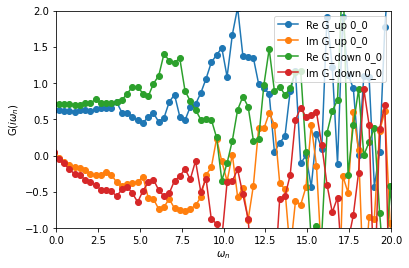

In [4]:
oplot(S.Sigma_iw, '-o')
plt.xlim(0,20)
plt.ylim(-1.0,2.0)

The large oscillations in the self-energy are due to a bad statistics in the Monte Carlo.

Exercise
--------

Increase and decrease the number of Monte Carlo cycles to see its effect on the quality of the self-energy.

     .... max_element |g(0) + g(beta) + 1| = 1
     .... max_element |g(0) + g(beta) + 1| = 1


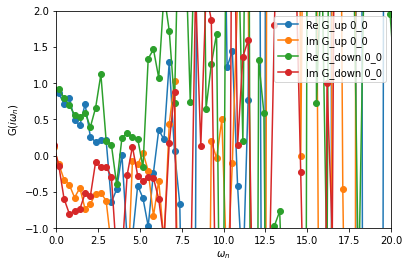

TRIQS : Received signal 2
     .... max_element |g(0) + g(beta) + 1| = 0.079331
     .... max_element |g(0) + g(beta) + 1| = 0.0290643


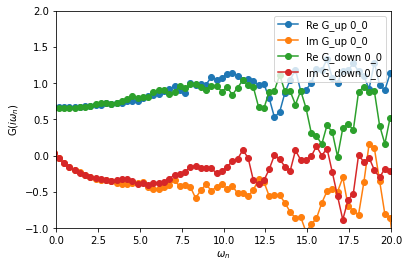

In [5]:
# Solve the impurity problem for a given local Hamiltonian.
S.solve(h_int = h_int, 
        length_cycle = 10,         # Number of steps between each measurement
        n_warmup_cycles = 5000,    # Number of warmup cycles
        n_cycles = 500           # Number of QMC cycles
       )

oplot(S.Sigma_iw, '-o')
plt.xlim(0,20)
plt.ylim(-1.0,2.0)
plt.show()


# Solve the impurity problem for a given local Hamiltonian.
S.solve(h_int = h_int, 
        length_cycle = 10,         # Number of steps between each measurement
        n_warmup_cycles = 5000,    # Number of warmup cycles
        n_cycles = 5000000          # Number of QMC cycles
       )

oplot(S.Sigma_iw, '-o')
plt.xlim(0,20)
plt.ylim(-1.0,2.0)
plt.show()

     .... max_element |g(0) + g(beta) + 1| = 0.0404281
     .... max_element |g(0) + g(beta) + 1| = 0.0582556


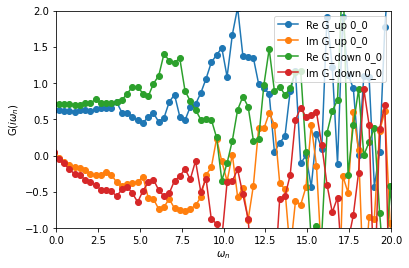

In [6]:
V = 1.0           # Hybridization strength
U = 4.0           # Local (on-site) Coulomb interaction
epsilon_d = 0.2   # Orbital energy level
beta = 20         # Inverse temperature

# Construct the impurity solver
S = Solver(beta = beta, gf_struct = [('up',[0]), ('down',[0])] )

# Define the non-interacting Green's function
S.G0_iw << inverse(iOmega_n - epsilon_d - V**2 * Flat(1.0))

# Define the interacting Hamiltonian
h_int = U * n('up',0) * n('down',0)

# Solve the impurity problem for a given local Hamiltonian.
S.solve(h_int = h_int, 
        length_cycle = 10,         # Number of steps between each measurement
        n_warmup_cycles = 5000,    # Number of warmup cycles
        n_cycles = 50000           # Number of QMC cycles
       )

oplot(S.Sigma_iw, '-o')
plt.xlim(0,20)
plt.ylim(-1.0,2.0)
plt.show()

In [24]:
t=1
#S.G0_iw << inverse(iOmega_n-t**2*S.G_iw)
S.G0_iw << iOmega_n
S.G0_iw << inverse(S.G0_iw -t**2*S.G_iw)

Green Function G composed of 2 blocks: 
 Greens Function G_up with mesh Matsubara Freq Mesh of size 2050, Domain: Matsubara domain with beta = 20, statistic = Fermion, positive_only : 0 and target_rank 2: 
 
 Greens Function G_down with mesh Matsubara Freq Mesh of size 2050, Domain: Matsubara domain with beta = 20, statistic = Fermion, positive_only : 0 and target_rank 2: 
 